In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [32]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [3]:
pl.rc('font', size = 25)
pl.rc('legend', fontsize = 25)
#sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
#trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')
sim = h5py.File('/disk1/lbignone/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/lbignone/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [20]:
# ok, lets calculate some ram pressures with only hot gas densities, this will be reduced a lot
Msun = 1.988*1e30
kpc = 3.086*1e19
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) 

def getTemp(gal, central):
    
    Temp, z, snaplist = [], [], []
    
    Idlist, snapst  = [], []
    
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][central]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    z2, z1 = -1., -1.
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        VelCen = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][iddC]
        VelGal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][idd]
        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

        pos = np.sqrt(np.sum((galPos-groupPos)**2))/r200
        
        offgal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][offgal[0]:offgal[1]]
        Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][offgal[0]:offgal[1]]
        Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][offgal[0]:offgal[1]]
        ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][offgal[0]:offgal[1]]
        
        tTemp = tempFromMass(Mass, Abund, IE, ne1)
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        if pos<2.:
            z2 = zs
        if pos<1.:
            z1 = zs
        
        if pos>2:
            break
        
        #ok, i thing i got what i need.
    
        # and now lost masses
        Temp.extend(list(tTemp))
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][offgal[0]:offgal[1]]
        snaplist.append(snap)
        z.append(zs)
        
        Idlist.extend(list(tempIds))
        snapst.extend([snap]*tempIds.size)
        
    Temp, z = np.array(Temp), np.array(z)
    snaplist = np.array(snaplist)
    
    Idlist = np.array(Idlist)
    snapst = np.array(snapst)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    Tempt = Temp[Idunique]
    snapst = snapst[Idunique]
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temp and snaps
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    Tempt_, Idlist_, snapst_ = Tempt[iidex_], Idlist[iidex_], snapst[iidex]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    Temporder = np.zeros(IndexT_.size)
    snaporder = np.zeros(IndexT_.size)
        
    Temporder[is1] = Tempt_[is2]
    snaporder[is1] = snapst_[is2]

    T, ET = [], []

    for s in snaplist:
        k = np.where(snaporder==s)
        TT = Temporder[k]
        T.append(np.median(TT))
        ET.append(np.sqrt(np.pi/2)*np.std(TT)/np.sqrt(TT.size))
        
    T, ET = np.array(T), np.array(ET)
    
    return z, T, ET

In [21]:
z_4338, T_4338, ET_4338 = getTemp(4338, 4337)

In [22]:
z_4339, T_4339, ET_4339 = getTemp(4339, 4337)

In [23]:
z_4341, T_4341, ET_4341 = getTemp(4341, 4337)

In [24]:
z_4343, T_4343, ET_4343 = getTemp(4343, 4337)

In [25]:
z_4470, T_4470, ET_4470 = getTemp(4470, 4469)

In [28]:
z_4471, T_4471, ET_4471 = getTemp(4471, 4469)

In [29]:
z_4473, T_4473, ET_4473 = getTemp(4473, 4469)

In [30]:
z_4474, T_4474, ET_4474 = getTemp(4474, 4469)

In [31]:
T_4474

array([           nan,            nan, 10071.76367188, 10829.06054688,
       10743.56933594, 10545.53027344, 10761.64697266, 10531.30664062,
       10940.61035156, 10334.46142578, 10359.88671875, 10911.40869141,
       10595.80126953, 10842.27099609, 10199.875     , 10170.94824219,
       10096.65185547, 10001.75195312,  9955.09179688, 10003.45507812,
       10030.29443359, 10001.51513672,  9999.43847656, 10005.61865234,
        9935.38232422, 10010.10546875, 10197.58447266, 10210.59423828,
       10290.37304688, 10059.05566406, 10217.09863281, 10516.14941406,
       10309.04833984])

In [33]:
Temp_4338 = Cosmo.lookback_time(z_4338).value
Temp_4339 = Cosmo.lookback_time(z_4339).value
Temp_4341 = Cosmo.lookback_time(z_4341).value
Temp_4343 = Cosmo.lookback_time(z_4343).value

Temp_4470 = Cosmo.lookback_time(z_4470).value
Temp_4471 = Cosmo.lookback_time(z_4471).value
Temp_4473 = Cosmo.lookback_time(z_4473).value
Temp_4474 = Cosmo.lookback_time(z_4474).value

Text(0, 0.5, 'Temperature/K')

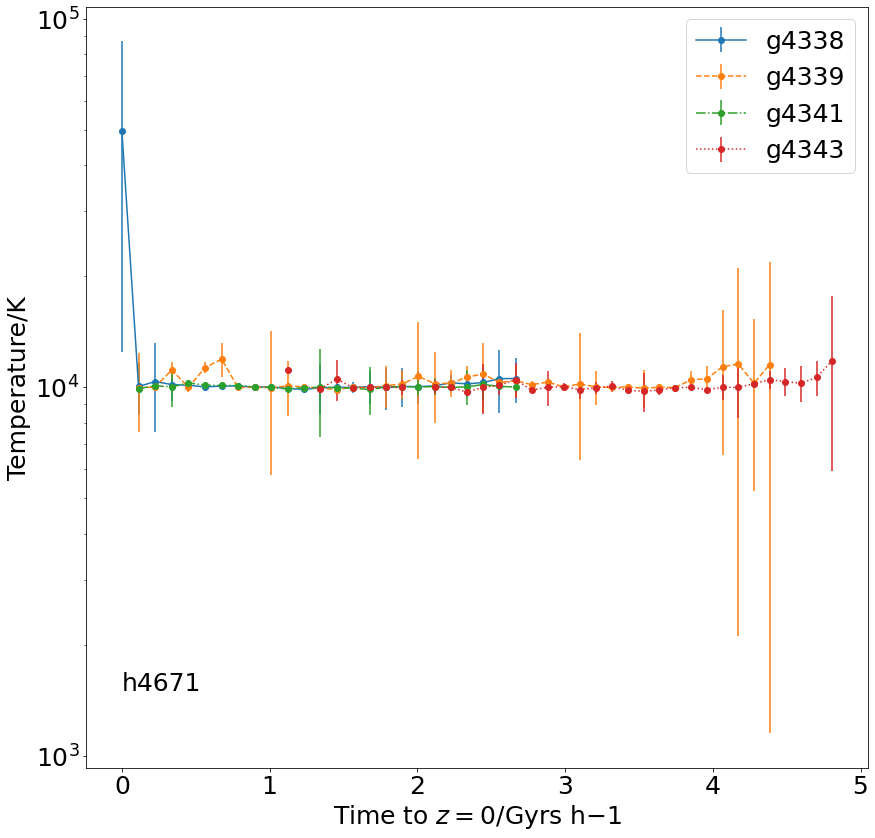

In [40]:
#ok, assuming that that is correct, wich i doubt
pl.figure(figsize=(14,14))

pl.yscale('log')

pl.errorbar(Temp_4338, T_4338, yerr=ET_4338, marker='o', ls='-', label='g4338')
pl.errorbar(Temp_4339, T_4339, yerr=ET_4339, marker='o', ls='--', label='g4339')
pl.errorbar(Temp_4341, T_4341, yerr=ET_4341, marker='o', ls='-.', label='g4341')
pl.errorbar(Temp_4343, T_4343, yerr=ET_4343, marker='o', ls=':', label='g4343')

pl.text(0, 1.5e3, 'h4671')

pl.legend(loc='best')

pl.xlabel('Time to $z=0$/Gyrs h${-1}$')
pl.ylabel('Temperature/K')

Text(0, 0.5, 'Temperature/K')

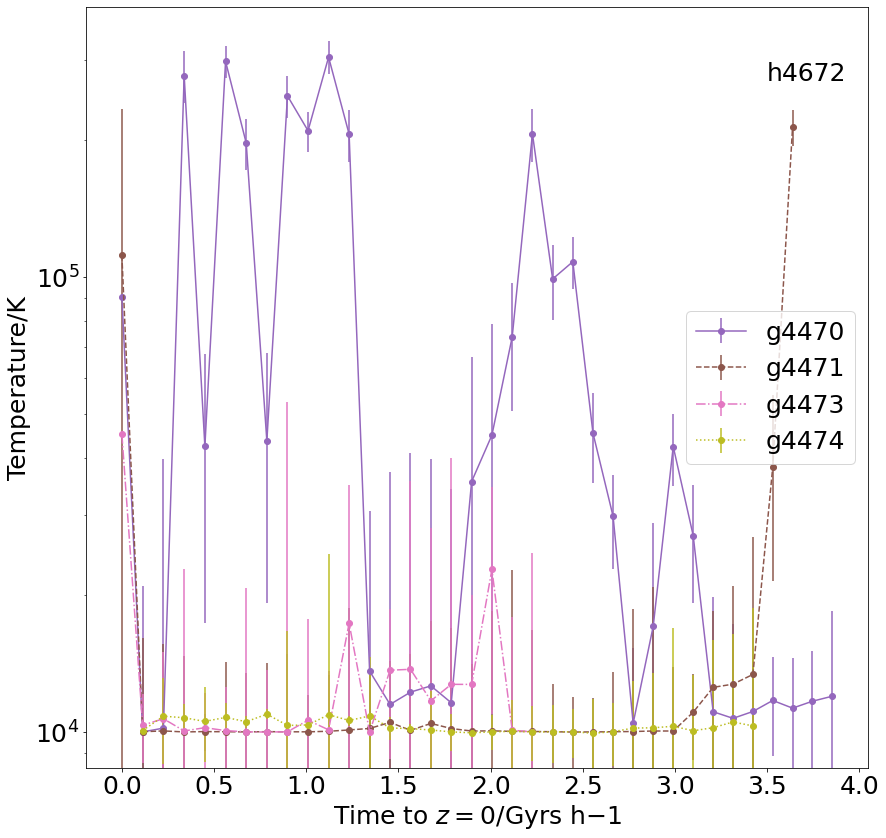

In [46]:
pl.figure(figsize=(14,14))

pl.yscale('log')

pl.errorbar(Temp_4470, T_4470, yerr=ET_4470, marker='o', ls='-', label='g4470', color='tab:purple')
pl.errorbar(Temp_4471, T_4471, yerr=ET_4471, marker='o', ls='--', label='g4471', color='tab:brown')
pl.errorbar(Temp_4473, T_4473, yerr=ET_4473, marker='o', ls='-.', label='g4473', color='tab:pink')
pl.errorbar(Temp_4474, T_4474, yerr=ET_4474, marker='o', ls=':', label='g4474', color='tab:olive')

pl.legend(loc='best')

pl.text(3.5, 2.7e5, 'h4672')

pl.xlabel('Time to $z=0$/Gyrs h${-1}$')
pl.ylabel('Temperature/K')